# Correlator Testing Notebook

### Import

In [2]:
import sys
sys.path.append(r"d:\Università\terzo anno\Tesi\astrocook")
from astrocook.functions import lines_voigt
from astropy.table import Table, vstack
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sps
from scipy.interpolate import interp1d
from tqdm import tqdm


### Gestione dati

In [3]:
##MAIN##

spectrum = Table.read('testCIV_7_spec.dat', format='ascii')
spectrum = Table([spectrum['x'], spectrum['y']], names=['wavelength', 'flux'])


In [4]:
wav_start = [154.8, 154.8, 155.06]
wav_end = [155.1, 154.85, 155.1]

#model parametrs
z = 0
logN = 12
b = 5
btur = 0
ion = 'CIV'


In [5]:
# models definition
models = [Table(), Table(), Table()]
for i in range(len(wav_start)):
    x = np.linspace(wav_start[i], wav_end[i], 1000)
    y = lines_voigt(x, z, logN, b, btur, ion)
    models[i] = Table([x, y], names=['wavelength', 'flux'])


In [6]:
#other parameters
threshold = 0.999
z_start = spectrum['wavelength'][0]/154.8 - 1
z_end = spectrum['wavelength'][-1]/155.1 - 1
#z_start = 2.56
#z_end = 2.63
dz = 1e-5

### Funzioni secondarie

In [7]:
#get indicies function
def get_indicies(flux, threshold):
    indicies = np.where(~(flux > threshold))[0]
    count = len(indicies)
    return indicies, count

# Function to convert bin to redshift
def bin_to_z(bin):
    return z_start + bin*dz

### Calcolo correlazione

In [155]:
cor_all = [np.array([]), np.array([]), np.array([])]

print("\n 3 models correlation calculation: \n - model 0 = full doublet \n - model 1 = left peak \n - model 2 = right peak \n")

for i,model in enumerate(models):
    for z in tqdm(np.arange(z_start, z_end, dz), "Calculating Correlation with model {}".format(i)):
        #moving the model to the redshift z
        new_model = Table([model['wavelength']*(1 + z), model['flux']], names=['wavelength', 'flux'])

        mask = (spectrum['wavelength'] > new_model['wavelength'].min()) & (spectrum['wavelength'] < new_model['wavelength'].max())    
        
        #selecting the data interval covered by the model
        spec_chunk = Table([spectrum['wavelength'][mask], spectrum['flux'][mask]], names=['wavelength', 'flux'])

        #interpolating the model to the data wavelength
        interpolate = interp1d(new_model['wavelength'], new_model['flux'], kind='linear')
        interpolated_flux = interpolate(spec_chunk['wavelength'])

        #identifying the indicies of the model that are below the threshold
        indicies, count = get_indicies(interpolated_flux, threshold)

        cor = np.correlate(interpolated_flux[indicies], spec_chunk['flux'][indicies], mode='valid')/count
        cor_all[i] = np.append(cor_all[i], cor)



 3 models correlation calculation: 
 - model 0 = full doublet 
 - model 1 = left peak 
 - model 2 = right peak 



Calculating Correlation with model 2: 100%|██████████| 52965/52965 [00:31<00:00, 1681.33it/s]


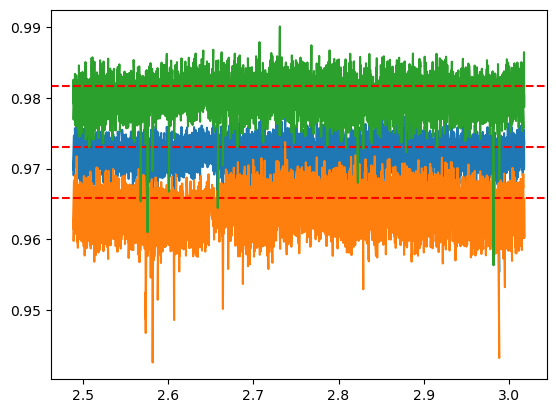

In [156]:
perc = 75

p0 = np.percentile(cor_all[0], perc)
p1 = np.percentile(cor_all[1], perc)
p2 = np.percentile(cor_all[2], perc)

cor_final = (p0 -cor_all[0])*(p1-cor_all[1])*(p2-cor_all[2])
#cor_normalized = (cor_final - cor_final.min())/(cor_final.max() - cor_final.min())
z_interval = np.arange(z_start, z_end, dz)

plt.plot(z_interval, cor_all[0], label='full doublet')
plt.axhline(p0, color='r', linestyle='--')
plt.plot(z_interval, cor_all[1], label='left peak')
plt.axhline(p1, color='r', linestyle='--')
plt.plot(z_interval, cor_all[2], label='right peak')
plt.axhline(p2, color='r', linestyle='--')


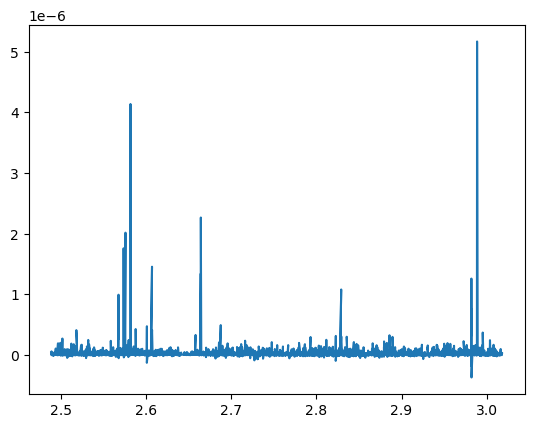

In [157]:
plt.plot(z_interval, cor_final, label='final correlation')

### Identificazione Picchi

In [158]:
from astrocook.astrocook import vars
def get_dlambda(ion):
    elements = {key: value for key, value in vars.xem_d.items() if ion in key}
    dlambda = (np.abs(float(elements[list(elements.items())[0][0]].value) - float(elements[list(elements.items())[1][0]].value)))/float(elements[list(elements.items())[0][0]].value)

    return dlambda

In [190]:
# Finding the peaks
peaks, properties = sps.find_peaks(cor_final, height=np.mean(cor_final) + np.std(cor_final)*2, prominence=0, width=0.01, distance = 5e-4/dz)
peaks_table = Table([bin_to_z(peaks), properties['peak_heights'], properties['widths'], bin_to_z(properties['left_ips']), bin_to_z(properties['right_ips']), properties['width_heights'], properties['prominences']], names=['z', 'height', 'fwhm', 'left_z', 'right_z', 'half_max', 'prominence'])

len(peaks_table)

41

In [198]:
# Function to find the peaks studying the delta_z between the peaks
def find_systems(peaks_table, ion = 'CIV', z_tolerance = 0.1e-3, height_threshold = 3):
    
    for peak in peaks_table[peaks_table['height'] > np.mean(cor_final) + np.std(cor_final)*height_threshold]:
        # Defining the theoretical redshifts of the sx and dx peaks
        delta_lambda = get_dlambda(ion)
        delta_z = delta_lambda * (1 + peak['z'])

        sx_z = peak['z'] - delta_z
        dx_z = peak['z'] + delta_z

        # Defining the masks to find the sx and dx peaks within the z_tolerance
        sx_mask = (peaks_table['z'] < sx_z + z_tolerance) & (peaks_table['z'] > sx_z - z_tolerance)
        dx_mask = (peaks_table['z'] < dx_z + z_tolerance) & (peaks_table['z'] > dx_z - z_tolerance) 
        height_mask = (peaks_table['height'] < peak['height'])
        not_peak_z_mask = (peaks_table['z'] != peak['z'])

        #identifying the sx and dx peaks
        sx_peak = peaks_table[sx_mask & height_mask & not_peak_z_mask]
        dx_peak = peaks_table[dx_mask & height_mask & not_peak_z_mask]

        # Removing the secondary peaks
        if((len(sx_peak) >= 1) & (len(dx_peak) >= 1)):
            for sx in sx_peak:
                peaks_table = peaks_table[peaks_table['z'] != sx['z']]
            for dx in dx_peak:
                peaks_table = peaks_table[peaks_table['z'] != dx['z']]
                
    return peaks_table


In [201]:
height_threshold = 3
z_tolerance = 0.15e-3
ion = 'CIV'

print(peaks_table['z'])

possible_systems = find_systems(peaks_table, ion, z_tolerance , height_threshold)

print(possible_systems['z'])

        z         
------------------
2.4964179328165375
 2.498277932816537
 2.500647932816537
2.5016279328165374
2.5180079328165372
2.5319879328165373
2.5584479328165375
2.5675379328165375
 2.573507932816537
2.5757279328165374
               ...
 2.880447932816537
 2.882767932816537
 2.885817932816537
2.8893579328165373
 2.954007932816537
2.9728979328165375
2.9820279328165373
2.9887079328165376
2.9953379328165375
3.0038579328165373
Length = 41 rows
        z         
------------------
2.4964179328165375
 2.498277932816537
 2.500647932816537
2.5016279328165374
2.5180079328165372
2.5319879328165373
2.5584479328165375
 2.573507932816537
2.5815979328165373
2.6008679328165374
               ...
2.8660779328165376
2.8794279328165375
 2.880447932816537
 2.882767932816537
 2.885817932816537
2.8893579328165373
 2.954007932816537
2.9728979328165375
2.9887079328165376
3.0038579328165373
Length = 33 rows


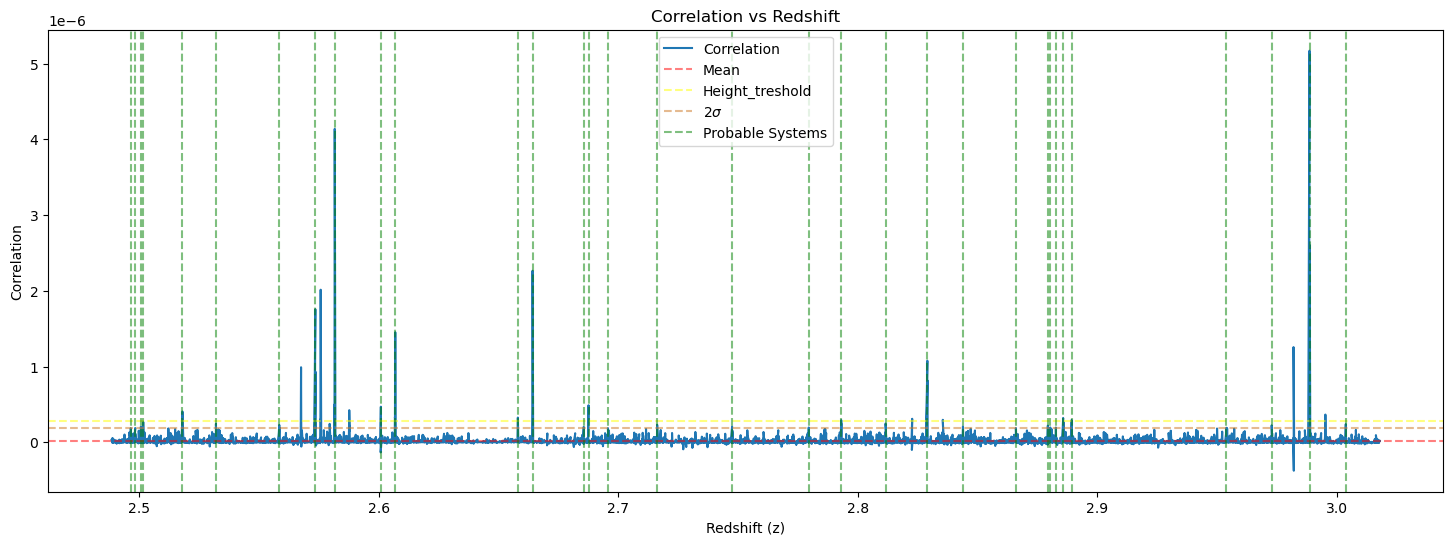

In [203]:

plt.figure(figsize = (18, 6))
plt.plot(z_interval, cor_final)
plt.axhline(np.mean(cor_final), color='r', linestyle='--', alpha=0.5)
plt.axhline(np.std(cor_final)*height_threshold + np.mean(cor_final), color='yellow', linestyle='--', alpha=0.5)
plt.axhline(np.std(cor_final)*2 + np.mean(cor_final), color='#CC7722', linestyle='--', alpha=0.5)

for system in possible_systems['z']:
    plt.axvline(x=system, color='g', linestyle='--', alpha=0.5)

plt.xlabel('Redshift (z)')
plt.ylabel('Correlation')
plt.title('Correlation vs Redshift')
plt.legend(['Correlation', 'Mean', r'Height_treshold', r'2$\sigma$', 'Probable Systems'])
plt.show()

In [206]:
synthetic_systems = [2.57352431, 2.66422603, 2.51803598, 2.22357274, 2.58163493, 2.21013991, 2.30970016, 2.82904971, 2.60683895, 2.95009428, 2.88590944, 2.27320993, 2.20884315, 3.08239514, 2.73699688, 2.30842111, 2.22430456, 2.68757115, 2.71786475, 2.98868828]


for i, p in enumerate(synthetic_systems):
    synthetic_systems[i] = round(p, 4)

n=0

not_found = []
for system in possible_systems['z']:
    system = round(system, 4)
    if(system in synthetic_systems):
        n+=1
        print(system, 'found')
    else:
        not_found.append(system)
        print(system, 'not found')

completness = n/len(synthetic_systems) * 100

print(completness, r'% of the synthetic systems have been found')
print(100 - completness, r'% of the synthetic systems have not been found')
print(len(not_found)/len(possible_systems)*100, r'% of the found systems are false positives')


2.4964 not found
2.4983 not found
2.5006 not found
2.5016 not found
2.518 found
2.532 not found
2.5584 not found
2.5735 found
2.5816 found
2.6009 not found
2.6069 not found
2.6581 not found
2.6642 found
2.6856 not found
2.6876 found
2.6957 not found
2.7163 not found
2.7475 not found
2.7796 not found
2.7931 not found
2.8116 not found
2.8291 not found
2.844 not found
2.8661 not found
2.8794 not found
2.8804 not found
2.8828 not found
2.8858 not found
2.8894 not found
2.954 not found
2.9729 not found
2.9887 found
3.0039 not found
30.0 % of the synthetic systems have been found
70.0 % of the synthetic systems have not been found
81.81818181818183 % of the found systems are false positives


___________________________________

## Testing

In [29]:
import matplotlib.pyplot as plt
from correlator_v2_nofs import correlator
import numpy as np


In [30]:
def plot_correlation(cor_final, z_interval, possible_systems):
    plt.figure(figsize=(20, 12))
    plt.plot(z_interval, cor_final)
    plt.axhline(np.mean(cor_final), color='r', linestyle='--', alpha=0.5)
    plt.axhline(np.std(cor_final) * 3 + np.mean(cor_final), color='yellow', linestyle='--', alpha=0.5)
    plt.axhline(np.std(cor_final) * 2 + np.mean(cor_final), color='#CC7722', linestyle='--', alpha=0.5)

    for system in possible_systems:
        plt.axvline(x=system, color='g', linestyle='--', alpha=0.5)

    plt.xlabel('Redshift (z)')
    plt.ylabel('Correlation')
    plt.title('Correlation vs Redshift (nofs)')
    plt.legend(['Correlation', 'Mean', r'3$\sigma$', r'2$\sigma$', 'possible Systems'])
    plt.show()

In [31]:
cor_final, z_interval, peaks_table = correlator()

TypeError: correlator() missing 10 required positional arguments: 'spectrum_file', 'wav_start', 'wav_end', 'logN', 'b', 'btur', 'ion', 'threshold', 'dz', and 'perc'

        z                  height         ...       prominence      
------------------ ---------------------- ... ----------------------
 2.573507932816537  1.756679923730793e-06 ... 1.8003313264901162e-06
 2.577047932816537 1.6017078235085078e-07 ...  1.630850357447301e-07
2.5815979328165373  4.138515114069596e-06 ...  4.195435055531804e-06
2.6008679328165374  4.699940204492135e-07 ...   5.73232834575959e-07
2.6068879328165373 1.4528478813097062e-06 ... 1.4784525130390424e-06
2.6580779328165374 3.2639286663269647e-07 ...  3.404453878097549e-07
 2.664217932816537  2.264758254650314e-06 ... 2.3979176656427845e-06
2.6855979328165374 2.0380697635936618e-07 ... 2.1054858513796154e-07
 2.687597932816537  4.889713169526631e-07 ...  5.514492397390261e-07
2.6895479328165375  1.485718416126336e-07 ...  1.592973880763628e-07
               ...                    ... ...                    ...
 2.954007932816537  1.917033183792563e-07 ... 2.2735997805914113e-07
 2.957257932816537 1.7966687329586

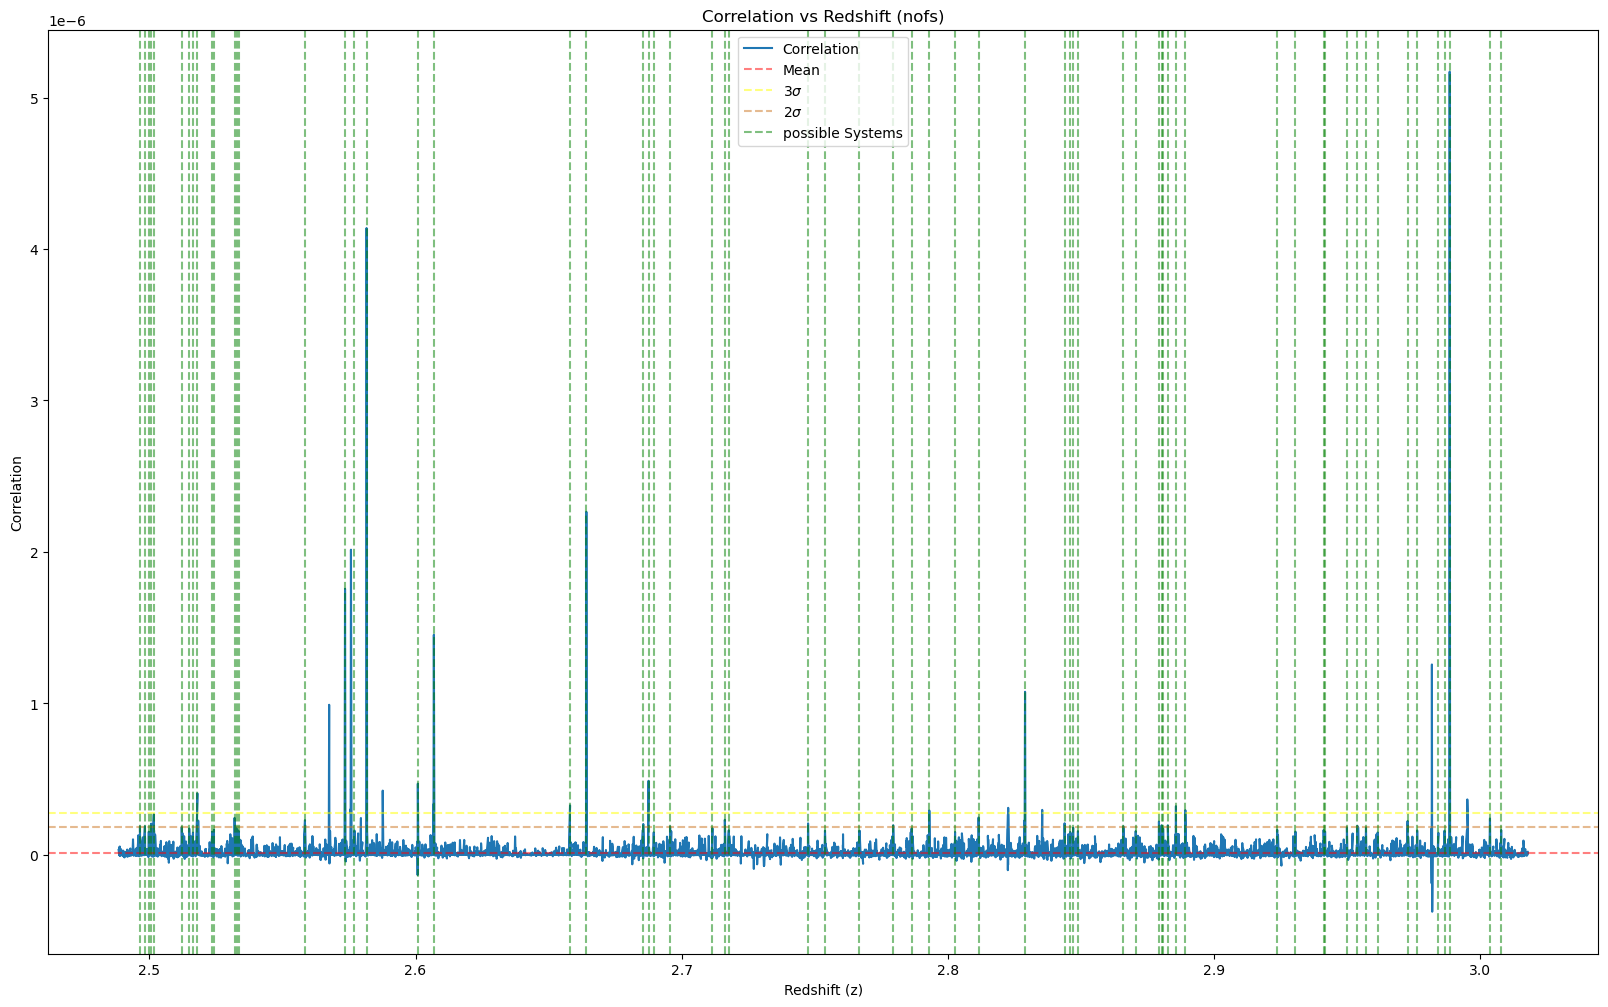

In [32]:
# Comparison with synthetic systems
synthetic_systems = [2.57352431, 2.66422603, 2.51803598, 2.22357274, 2.58163493, 2.21013991, 2.30970016, 2.82904971, 2.60683895, 2.95009428, 2.88590944, 2.27320993, 2.20884315, 3.08239514, 2.73699688, 2.30842111, 2.22430456, 2.68757115, 2.71786475, 2.98868828]
print(peaks_table[peaks_table['z'] > 2.56])

tp = sum(1 for system in peaks_table['z'] if any(abs(system - syn) < 1.665*b/3e5 for syn in synthetic_systems))

fp = len(peaks_table['z']) - tp
p = len(synthetic_systems)

recall = tp / p * 100
precision = tp / (tp+fp) * 100
f1 = 2 * tp / (tp + fp + p) * 100

print('Recall:', recall, '%')
print('Precision:', precision, '%')
print('F1 score:', f1, '%')

plot_correlation(cor_final, z_interval, peaks_table['z'])



